# User Equilibrium Assignment
この `notebook` では，利用者均衡配分を Frank-Wolfe 法で解くためのアルゴリズムを解説する．

(静的)***利用者均衡(*User Equilibrium*: UE)配分***とは，下記の3つの情報:
- 道路ネットワーク構造
- 各リンクの性能関数
- 各起終点(OD: *origin-destination*)ペアの交通需要

を与件として，

> どの利用者についても，自分だけが経路を変更することではそれ以上交通費用を改善できない状態(フロー・パターン)

と定義される．

UEモデルおよびその解法の特徴的な点は，以下の2点である: 

1. 経路を明示的に考慮する必要のない，ノード/フロー変数のみで均衡条件を記述する．
2. 均衡状態を求める問題が，凸計画問題に帰着することを活用する．

これにより，リンク性能関数が特定の条件[<sup>1</sup>](#fn1)を満足するならば，ODペアが多起点・多終点で，リンクが数千本存在するような一般ネットワークに対しても，本 `notebook` で示す Frank-Wolfe 法によって，(そこそこ)効率的に均衡解が求められる．以下，UEモデルを簡単に解説し，その具体的解法を示そう．

-----
<span id="fn1">[<sup>1</sup>]()リンク性能関数のJacobianが対称かつ半正定値であれば，本 `notebook` で示す解法が適用できる．</span>

# User Equilbirium and Its Equivalent Convex Programming

## Road Network, Travel Demand, Link Performance and Path Cost
道路ネットワークを有向グラフ(directed graph) $\mathcal{G}(\mathcal{N}, \mathcal{L})$ で表す．
ここで，$\mathcal{L}$はリンク集合, $\mathcal{N}$はノード集合である．以下では，ノード数を$N$, リンク数を$L$で表す．
交通需要の起点ノードおよび終点ノードの集合[<span>2</span>](#fn2)を, それぞれ, $\mathcal{O}, \mathcal{D} \subseteq \mathcal{N}$で表し，
起終点ペアの集合を$\mathcal{W} = \mathcal{O}\times\mathcal{D}$で表し，その要素数を$W$で表す．
起終点ペア$(r,s) \in \mathcal{W}$の交通需要を，所与の定数$q^{rs}$で表す．

道路ネットワークの構造は，ノード-リンク接続行列$\mathbf{A}$で表される．この行列の次元は$N\times L$であり，その$n$行$ij$列要素$a_{n, ij}$が
$$
a_{n, ij} = \begin{cases}
1 & \text{if $n=i$ (node $n$ is the upstream of link $ij$)} \\
-1 & \text{if $n=j$ (node $n$ is the downstream of link $ij$}) \\
0 & \text{otherwise}
\end{cases}
$$
で定義される．

起終点ペア$(r,s) \in \mathcal{W}$に対する経路集合を$\mathcal{K}^{rs}$で表し，その要素数を$K^{rs}$で表す．経路$k \in \mathcal{K}^{rs}$上の単位時間あたり交通量\[台/分\]を **経路$k$のフロー** (path flow) と呼び，$f_{k}^{rs}$で表す．ベクトル$\mathbf{f}=\left\{f_{k}^{rs} : k \in \mathcal{K}^{rs}, (r,s) \in \mathcal{W}\right\}$ を経路フローと呼び，その次元を$K = \sum_{rs\in\mathcal{W}}K^{rs}$ で表す．経路フローは，以下のフロー保存則と非負制約を満足する時，**実行可能(feasible)である**という:
$$
\begin{cases}
\sum_{k \in \mathcal{K}^{rs}} f_{k}^{rs} = q^{rs}\\
f_{k}^{rs} \geq 0, \quad \forall k \in \mathcal{K}^{rs}
\end{cases},
\qquad \forall (r, s) \in \mathcal{W}
$$

リンク$(i,j)$上の単位時間あたり交通量\[台/分\]を **リンク$(i,j)$のフロー** (link flow)と呼び，$x_{ij}$で表す. ベクトル$\mathbf{x} = \left\{x_{ij}: (i, j) \in \mathcal{L}\right\}$をリンク・フローと呼ぶ．
経路フロー$\mathbf{f}$とリンク・フロー$\mathbf{x}$の間には，以下の関係が成立する:
$$
\mathbf{x} = \mathbf{\Delta} \mathbf{f}.
$$
ここで，$\mathbf{\Delta}$は，その次元が$L\times{}K$であり，その$ij$行$krs$列要素$\delta_{ij, k}^{rs}$が，以下の Kronecker's delta で表される:
$$
\delta_{ij, k}^{rs} = \begin{cases}
1 & \text{if link $ij$ is on path $k$ of O-D pair $rs$} \\
0 & \text{otherwise}
\end{cases}
$$
上式は，下記のように要素表示することもできる:
$$
x_{ij} = \sum_{(r,s) \in \mathcal{W}} \sum_{k \in \mathcal{K}^{rs}} \delta_{ij, k}^{rs} f_{k}^{rs}
$$

フローに依存するリンク$(i, j)$の交通費用を，当該リンク・フローの非減少関数$t_{ij}(x_{ij})$で表し，**リンク$(i, j)$の性能関数** (performance function)と呼ぶ．交通工学分野で用いられる代表的なリンク性能関数として, 以下のBPR (*Bureau of Public Roads*)型が挙げられる:
$$t_{ij}(x_{ij}) = t_{0, ij}\left\{1 + \beta\left(\frac{x_{ij}}{\mu_{ij}}\right)^{\gamma}\right\}$$
  - $t_{0, ij}$ : リンク$(i, j)$の自由走行時間\[分\]
  - $\mu_{ij}$ : リンク$(i, j)$の道路容量\[台/分\] (単位時間あたりに通過可能な台数)
  - $\beta, \gamma$ : パラメータ．ただし，$\beta \geq 0$, $\gamma \geq 1$.
  
リンクの交通費用が$\mathbf{t} = \left\{t_{ij}: (i, j) \in \mathcal{L}\right\}$である時，起終点ペア$(r, s) \in \mathcal{W}$ の経路$k \in \mathcal{K}^{rs}$の費用は
$$
C_{k}^{rs} = \sum_{(i, j) \in \mathcal{L}} \delta_{ij, k}^{r} t_{ij}
$$
と表せる．経路費用ベクトルを$\mathbf{C} = \left\{C_{k}^{rs}: k \in \mathcal{K}^{rs}, (r, s) \in \mathcal{W}\right\}$と表す時，上式は
$$
\mathbf{C} = \mathbf{\Delta}^{\top} \mathbf{t}
$$
とも表現できる．

-----

<span>[<sup>2</sup>]() 実際の交通需要は道路ネットワーク上に実在する特定の物理的なノードで発生/集中する訳ではないため，需要が発生/集中する仮想的なノードを設けるのが一般的である．このため，物理的な道路ネットワーク上の通過ノードと区別するために，起点/終点ノードを **ゾーン** と呼ぶこともある．</span>

## User Equilibrium
経路フロー$\mathbf{f}$に対する経路交通費用$\mathbf{C}(\mathbf{f})$を，以下の関数で表す:
$$
\mathbf{C}(\mathbf{f}) = \mathbf{\Delta}^{\top} \mathbf{t}\left(\mathbf{\Delta} \mathbf{f}\right)
$$

実行可能な経路フロー$\mathbf{f}$は，下記を満足する時，**利用者均衡(UE)状態** であると言う:
> 任意の起終点ペアについて，どの利用者も，自分だけが経路を変更することではそれ以上経路費用を改善できない状態．

均衡状態においては，明らかに，以下の **Wardrop原則** が成立する:
> 任意の起終点ペアについて，利用されている経路の費用はいずれも等しく，利用されていない経路の費用がそれを下回ることはない．

均衡経路フローを$\mathbf{f}^{\ast} = \{f_{k}^{\ast rs}\}$ で表し，起終点ペア$(r, s)$の最小費用(**均衡費用(equilibrium cost)** と呼ぶ)を
$$
\rho^{\ast rs} = \min_{k \in \mathcal{K}^{rs}} C_{k}^{rs}(\mathbf{f}^{\ast})
$$ 
で表す時，上記Wardrop原則は以下の **相補性条件(complimentarity condition)** として記述できる:
$$
\begin{cases}
f_{k}^{\ast rs} > 0 &\rightarrow C_{k}^{rs}(\mathbf{f}^{\ast}) = \rho^{\ast rs} \\
f_{k}^{\ast rs} < 0 &\leftarrow C_{k}^{rs}(\mathbf{f}^{\ast}) > \rho^{\ast rs} 
\end{cases}
\quad \forall k \in \mathcal{K}^{rs}, \forall (r, s) \in \mathcal{W} 
$$
この条件は，以下のように1行にまとめて記述することもできる:
$$
0 \leq f_{k}^{\ast rs} \bot \left\{C_{k}^{rs}(\mathbf{f}^{\ast}) - \rho^{\ast rs}\right\} \geq 0,
\qquad \forall k \in \mathcal{K}^{rs}, \forall (r,s) \in \mathcal{W}
$$
ここで，$0 \leq a \bot b \geq 0$ は，$a \geq 0, b \geq 0$ かつ $ab = 0$ であることを表している．
上記の最適経路選択条件と経路フローの実行可能性条件を，合わせて以下の相補性条件として記述しておくと便利である:
$$
\begin{align}
0 \leq f_{k}^{\ast rs} &\bot \left\{C_{k}^{rs}(\mathbf{f}^{\ast}) - \rho^{\ast rs}\right\} \geq 0, && \forall k \in \mathcal{K}^{rs}, \forall (r,s) \in \mathcal{W}\\
0 \leq \rho^{\ast rs} &\bot q^{rs} - \sum_{k \in \mathcal{K}^{rs}} f_{k}^{\ast rs} \geq 0, && \forall (r,s) \in \mathcal{W} 
\end{align}
$$

こうして相補性条件として記述された利用者均衡条件は，下記の凸計画問題の最適性(KKT: *Karush-Kuhn-Tucker*)条件と等価である：
$$
\begin{alignat}{3}
\text{[P-path]} \qquad \min_{\mathbf{f}} \quad &
Z(\mathbf{x}(\mathbf{f})) :=
\sum_{(i, j) \in \mathcal{L}}
\int_{0}^{x_{ij}(\mathbf{f})} t_{ij}(\omega) \mathrm{d}\omega
\\
\text{Sub to.} \quad 
&\sum_{k \in \mathcal{K}^{rs}} f_{k}^{rs} = q^{rs} , \quad \forall (r, s) \in \mathcal{W}, \\
&f_{k}^{r, s} \geq 0, \quad \forall k \in \mathcal{K}^{rs}, \forall (r, s) \in \mathcal{W} 
\end{alignat}
$$
ただし，$x_{ij}(\mathbf{f}) = \sum_{(r, s) \in \mathcal{W}} \sum_{k \in \mathcal{K}^{rs}} \delta_{ij, k}^{rs} f_{k}^{rs}$(i.e. $\mathbf{x}(\mathbf{f}) = \mathbf{\Delta} \mathbf{f}$) である．

具体的には，\[P\]のフロー保存則$\sum_{k \in \mathcal{K}^{rs}} f_{k}^{rs} = q^{rs}$ に対応する双対変数を $\rho^{rs}$ とし，$\boldsymbol{\rho} = \{\rho^{rs}: (r, s) \in \mathcal{W}\}$ として Lagrangian を
$$
L(\mathbf{f}, \boldsymbol{\rho}) = Z(\mathbf{x}(\mathbf{f})) + 
\sum_{(r, s) \in \mathcal{W}} \rho^{rs} \left\{ q^{rs} - \sum_{k \in \mathcal{K}^{rs} } f_{k}^{rs}\right\}
$$
と定義すれば，
$$
\begin{align}
\frac{\partial L}{\partial f_{k}^{rs}} &= \sum_{(i, j) \in \mathcal{L}} \frac{\partial Z}{\partial x_{ij}} \frac{\partial x_{ij}}{\partial f_{k}^{rs}} - \rho^{rs} = \sum_{(i, j) \in \mathcal{L}} t_{ij}\left(x_{ij}(\mathbf{f})\right) \delta_{ij, k}^{rs} - \rho^{rs}
= C_{k}^{rs}(\mathbf{f}) - \rho^{rs}
\\
\frac{\partial L}{\partial \rho^{rs}} &= q^{rs} - \sum_{k \in \mathcal{K}^{rs}} f_{k}^{rs}
\end{align}
$$
より，問題\[P-path\]の最適性条件
$$
\begin{align}
0 \leq f_{k}^{rs} &\bot \frac{\partial L}{\partial f_{k}^{rs}} \geq 0 && \forall k \in \mathcal{K}^{rs}, \forall (r,s) \in \mathcal{W}\\
0 \leq \rho^{rs} &\bot \frac{\partial L}{\partial \rho^{rs}} \geq 0 && \forall (r,s) \in \mathcal{W}
\end{align}
$$
が，相補性条件として記述された均衡条件と等価であることが容易に確認できる．

## Link-Node Representation
上述の記述・分析は経路変数を未知変数として用いるが，経路の本数はネットワークの規模について指数関数的に増加するため，数百ノード・数千リンクといった大規模なネットワークを対象とする場合は，経路変数ではなく，ノード・リンク変数を用いた記述・分析の方が都合がよい．

まず，起終点ペア$(r,s)$のリンク・フローを$\mathbf{x}^{rs} = \{x_{ij}^{rs}: (i, j) \in \mathcal{L}\}$ で表そう
(後述するように，リンク・フローは起終点ペアごとに区別する必要はなく，起点もしくは終点について区別できれば十分である)．
このとき，経路ベースのフロー保存則
$$
\sum_{k \in \mathcal{K}^{rs}} f_{k}^{rs} = q^{rs}
$$
は，下記の各ノードでのフロー保存則と等価である:
$$
\sum_{ni \in \mathcal{L}} x_{ni}^{rs} - \sum_{im \in \mathcal{L}} x_{im}^{rs} = 
\begin{cases}
- q^{rs} & \text{if $i=r$ ($i$ is the origin)} \\
q^{ri} & \text{if $i=s$ ($i$ is the destination)} \\
0 & \text{otherwise}
\end{cases} \quad \forall i \in \mathcal{N}
$$
(以下，執筆予定)

結局のところ，利用者均衡配分問題は，以下の(起点別)リンク変数のみを未知変数とした凸計画問題に帰着する:
$$
\begin{alignat}{3}
\text{[P]} \qquad 
\min_{\mathbf{x}} &Z(\mathbf{x}) := \sum_{ij \in \mathcal{L}} \int_{0}^{x_{ij}} t_{ij}(\omega) \mathrm{d}\omega\\ 
\text{Sub to}\quad &
\sum_{ni \in \mathcal{L}} x_{ni}^{r} - \sum_{im \in \mathcal{L}} x_{im}^{r} = 
q^{ri} \quad && \forall i \in \mathcal{N}_{-r}, \forall r \in \mathcal{N} \\
& x_{ij} = \sum_{r \in \mathcal{N}} x_{ij}^{r} && \forall ij \in \mathcal{L} \\
& x_{ij}^{r} \geq 0 && \forall ij \in \mathcal{L}, \forall r \in \mathcal{N}
\end{alignat}
$$

# Frank-Wolfe Method for Solving The Equivalent Convex Programming
等価最適化問題\[P\]は，Frank-Wolfe法と呼ばれるアルゴリズムを用いて解くことができる．この方法は，許容領域(非負制約とフロー保存則が満足される)の中で，下記の2つのステップを繰返すことで目的関数がより小さくなるように解を改訂し，最適化問題の解(i.e. 均衡配分)を求める．
1. 等価最適化問題の目的関数が小さくなる方向(降下方向)を求める．
2. 降下方向に沿った移動量(ステップ・サイズ)を求め，解を改訂する．

## Auxiliary Problem and Descent Direction
いま，$n$番目繰返しにおける暫定解(配分)を$\mathbf{x}^{(n)}$で表し，$Z^{(n)} = Z(\mathbf{x}^{(n)})$ としよう．この暫定解の周りで[P]の目的関数$Z(\mathbf{x})$を線形近似したものは，
$$
Z(\mathbf{y}) \approx Z^{(n)} + {\nabla Z(\mathbf{x}^{(n)})}^{\top}\left( \mathbf{y} - \mathbf{x}^{(n)}\right)
$$
と表せる．ここで，$\nabla Z(\mathbf{x}^{(n)}) = \left(\frac{\partial Z}{\partial x_{ij}^{r}}(\mathbf{x}^{(n)})\right)$ は，目的関数の勾配ベクトルを表す．

ここで $\frac{\partial Z}{\partial x_{ij}^{r}}(\mathbf{x}^{(n)}) = t_{ij}(x_{ij}^{(n)}) = t_{ij}^{(n)}$ と書くことにすれば，許容領域の中で線形近似された目的関数を最小化させる配分$\mathbf{y}$は，以下の線形計画問題(**補助問題**と呼ぶ)の解として得られる:
$$
\begin{alignat}{3}
\text{[AP]} \qquad 
\min_{\mathbf{x}} &\sum_{r \in \mathcal{N}} \sum_{ij \in \mathcal{L}} t_{ij}^{(n)} y_{ij}^{r} \\ 
\text{Sub to}\quad &
\sum_{ni \in \mathcal{L}} y_{ni}^{r} - \sum_{im \in \mathcal{L}} y_{im}^{r} = 
q^{ri} \quad && \forall i \in \mathcal{N}_{-r}, \forall r \in \mathcal{N} \\
& y_{ij}^{r} \geq 0 && \forall ij \in \mathcal{L}, \forall r \in \mathcal{N}
\end{alignat}
$$

ここで，補助問題[AP]は AoN (*all-or-nothing*)配分問題となっていることに注意されたい．すなわち，各起点$r$について，各終点$i \in \mathcal{N}_{-r}$への最短経路上に全ての交通量$q^{ri}$を配分したものが[AP]の解となる．

こうして得られた補助問題の解(**補助解**と呼ぶ)を$\mathbf{y}^{(n)}$ と書き，現在の暫定解との差$\mathbf{d}^{(n)} = \mathbf{y}^{(n)} - \mathbf{x}^{(n)}$ を**降下方向**と呼ぶ．

## Linear Search of Step-Size and Update the Solution
暫定解$\mathbf{x}^{(n)}$から降下方向$\mathbf{d}^{(n)}$に沿って「どれだけ移動するか」を決定する．次の暫定解の候補を
$$
\mathbf{x}^{(n)}(\alpha) = \mathbf{x}^{(n)} + \alpha \mathbf{d}^{(n)}
$$
で表す．ここで，$\alpha$は移動の大きさ表す変数(**ステップ・サイズ**と呼ばれる)で，$0 \leq \alpha \leq 1$ となるように選べば，次の暫定解が許容領域からはみ出すことは無い．

ステップ・サイズは，以下の一次元探索(linear search):
$$
\min_{0\leq \alpha\leq1} Z^{(n)}(\alpha) = Z\left(\mathbf{x}^{(n)}\right)
$$
の解として求めることができ，そのための手続きとして黄金分割法(golden section method)などが知られている．ただし，最適なステップ・サイズを時間をかけて高精度に求めても計算全体の効率性は向上しないことが知られており，大規模なネットワークでは，Armijo の規則などを使って適当な回数で打ち切るのが現実的である．

こうして得られたステップ・サイズを$\alpha^{(n)}$ で表し，暫定解を以下のように改訂する：
$$
\mathbf{x}^{(n+1)} := \mathbf{x}^{(n)} + \alpha^{(n)} \mathbf{d}^{(n)}
$$

## Convergion Test
Frank-Wolfe法では，上述の2つの手続き---補助問題の求解, ステップ・サイズの決定---を，均衡解が求められるまで繰返す．
手続きを繰返すほど，より均衡解に近い暫定解が得られることが保証されるが，一般的には，暫定解が適当な収束条件を満足した時点で停止させる．
代表的な収束条件として，以下の3つを挙げておく．ただし，以下では，$\epsilon$ を十分に小さい定数とする．：

1. 目的関数の変化率  
  $n$回目繰返しにおける等価最適化問題の目的関数値を$Z^{(n)}$ と記述する時，
  $$\frac{Z^{(n-1)} - Z^{(n)}}{Z^{(n-1)}} \leq \epsilon$$
  が満たされれば収束と判定.
  
2. リンクフローの変化率
  $n$回目繰返しにおけるリンクフローを$x_{ij}^{(n)}$ と記述する時，
  $$\frac{\sqrt{
  \sum_{ij \in \mathcal{L}}
  \left(x_{ij}^{(n)} - x_{ij}^{(n-1)}\right)^{2}
  }
  }
  {\sum_{ij} x_{ij}^{(n-1)}} \leq \epsilon$$
  が満たされれば収束と判定.
  
3. 各起終点間の最小交通費用の変化率
  $n$回目繰返しにおける，起点$r$からノード$i(\ne r)$への最小交通費用を$\pi_{i}^{r(n)}$ と記述する時,
  $$
  \sum_{rs \in \mathcal{W}}
  \frac{\left|
  \pi_{i}^{r(n)} - \pi_{i}^{r(n-1)}
  \right|
  }
  {\pi_{i}^{r(n-1)}} \leq \epsilon$$
  が満たされれば収束と判定.


# Python Implementation
上述の手法を，Pythonで実装してみよう．与えるネットワーク/交通需要データは [https://github.com/bstabler/TransportationNetworks](https://github.com/bstabler/TransportationNetworks) で公開されているものを用いる．
データの読み取りは若干テクニカルなので，ここでは本教材用の実装済モジュール `TNTP` を使ってしまおう．

In [4]:
import numpy as np
import scipy as sp
from scipy import sparse
from operator import itemgetter, attrgetter
from IPython.lib.pretty import pprint
import TNTP # 
root = 'data' # データフォルダのルート
dir_name = 'SiouxFalls' # ネットワーク・データの格納されたフォルダ名
ntw = TNTP.Network(root, dir_name)

net file:	data/SiouxFalls/SiouxFalls_net.tntp
trips file:	data/SiouxFalls/SiouxFalls_trips.tntp


## `TNTP` Module and `Network` class
上記のコードを実行すると, Network型のインスタンス `ntw` が生成される．この `ntw` は以下のメンバ変数を持つ:
- `links_bn` : `_net.tntp` に記載されているリンクのリスト
- `nodes_bn` : `links_bn` に登場するノード番号を昇順に並べたリスト．途中で欠番がある可能性もある．
- `nid_of` : `nodes_bn` のノード番号を0から始まるリストのインデックスに対応させる辞書(`nid_of[1]`は1番ノードのリスト・インデックス)．
- `nodes` : ノード集合(`nodes_bn` 0から始まる連続した整数のインデックス)
- `links` : `links_bn` のノード番号を `nodes` に対応したインデックスに置き換えたもの
- 'lid_of' : 'links' のノード・インデックス・ペアをリンクのインデックスに対応させる辞書
- `fftt` : 各リンクの自由走行時間\[分\](`float`型の`numpy.array`)
- `capacity` : 各リンクの容量\[台/分\](`float`型の`numpy.array`)
- `b` : 各リンクのBPR関数の$\beta$ (`float`型の`numpy.array`)
- `power` : 各リンクのBPR関数の$\gamma$ (`float`型の`numpy.array`)

さらに，メンバ関数として以下を持つ：

- `t(x)` : リンク数次元のnp.array型ベクトルを引数として，同次元のリンク費用(BPR関数)を返す
- `t_mat(x)` : `t(x)`で得られるリンク費用を`sparse.csr_matrix`型の行列で返す(最短経路探索に利用)

In [7]:
# リンクのリスト
pprint(ntw.links_bn, max_seq_length=10)

((1, 2),
 (1, 3),
 (2, 1),
 (2, 6),
 (3, 1),
 (3, 4),
 (3, 12),
 (4, 3),
 (4, 5),
 (4, 11),
 ...)


## Equivalent Convex Programming
利用者均衡配分問題の等価最適化問題\[P\]の目的関数:
$$
Z(\mathbf{x}) := \sum_{ij \in \mathcal{L}} \int_{0}^{x_{ij}} t_{ij}(\omega) \mathrm{d}\omega
$$
を求めるためには，リンク性能関数の積分$T_{ij}(x_{ij}) = \int_{0}^{x_{ij}} t_{ij}(\omega) \mathrm{d}\omega$ を求める必要がある．リンク性能関数がBPR関数$t_{ij}(x_{ij}) = t_{0,ij}\left\{1 + \beta(x_{ij}/\mu_{ij})^{\gamma}\right\}$ である場合，
$$
T_{ij}(x) = t_{0,ij} x_{ij} \left\{1 + \frac{\beta}{1+\gamma}\left(\frac{x_{ij}}{\mu_{ij}}\right)^{\gamma}\right\}
$$
である．$T_{ij}(x)$は手計算でも求められるが，以下のように `sympy` を用いて求めることもできる：

In [8]:
import sympy # import symbolic math module
x, t0, mu, beta, gamma = sympy.symbols(('x', 't0', 'mu', 'beta', 'gamma')) # define unknowns
t = t0*(1+beta*(x/mu)**gamma) 
T = sympy.simplify(sympy.integrate(t, x)) # intergrate the link performance tij function w.r.t. x

In [9]:
# The original link performance function, tij, can be reproduced by differentiating Tij.
t_repro = sympy.simplify(sympy.diff(T,x))
#sympy.simplify(sympy.diff(t0*x*(1+beta/(1+gamma)*(x/mu)**gamma), x))
print("T:")
display(T)
print("t (reproduced by differentiating T):")
display(t_repro)

T:


Piecewise((t0*x*(beta*x**gamma*(1/mu)**gamma + gamma + 1)/(gamma + 1), Ne(gamma, -1)), (t0*(beta*mu*log(x) + x), True))

t (reproduced by differentiating T):


Piecewise((t0*(beta*x**gamma*(1/mu)**gamma + 1), Ne(gamma, -1)), (t0*(beta*mu + x)/x, True))

`TNTP` クラスには，この積分されたリンク性能関数およびそれを用いた等価最適化問題の目的関数値を評価する関数を用意している:
- `T(x)` : リンク数次元のnp.array型ベクトル$x$ を引数として，同次元の積分されたリンク費用を返す
- `Z(x)` : 等価最適化問題の目的関数値を返す

## Shortest Path Search
Frank-Wolfe法の補助問題の求解で必要となる最短経路探索を解くための Dijkstra法は `scipy.sparse.csgraph.dijkstra` で実装されている．
これを呼び出すためには，一度，ノード間の距離行列を，`scipy.sparse.csr_matrix`型の疎行列として作成する必要がある．
`scipy.sparse.csr_matrix` は，各リンクの所要時間 `cost` とリンク・インデックス集合 `ntw.links` を用いた以下のコマンドで定義できる:
```
w = scipy.sparse.csr_matrix((cost, zip(*ntw.links)))
```
ここで，`zip(*ntw.links)` は「発着ノードペアのリスト」を「発ノードリストと着ノードリストのペア」に置き換えるコマンド．

In [10]:
# Create the weight matrix by using the free flow travel time as the link cost
w = sparse.csr_matrix((ntw.fftt, zip(*ntw.links)))

In [26]:
# 疎行列として定義された重み行列を標準の行列として表示させる
pprint(w.toarray().tolist(), max_seq_length=10)

[[0.0, 6.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...],
 [6.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, ...],
 [4.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...],
 [0.0, 0.0, 4.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...],
 [0.0, 0.0, 0.0, 2.0, 0.0, 4.0, 0.0, 0.0, 5.0, 0.0, ...],
 [0.0, 5.0, 0.0, 0.0, 4.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, ...],
 [0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 0.0, 10.0, 0.0, ...],
 [0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 10.0, 0.0, 3.0, ...],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, ...],
 ...]


こうして用意された重み行列 `w` を用いれば，`scipy.sparse.csgraph.dijkstra` によって任意の起点から各ノードへの最短経路を計算できる．具体的には，ノード・インデックス `orig` から各ノードへの最短経路を得るコードは以下のように表せる:
```
pi, pred = scipy.sparse.csgraph.dijkstra(w,indices=orig,return_predecessors=True)
```
戻り値は，それぞれ，
- `pi`: 起点から各ノードへの最短経路費用
- `pred` : 各ノードの最短経路上の先行ポインタ(predecessor)．起点ノードなど，先行ポインタが無ければ`-9999`.

である．ここで，それぞれのオプションは，下記の意味を持つ:

- `indices`: 最短経路の起点インデックス．リストとして複数与えることも可能. 省略すると，全てのノードを起点とする最短経路を探索．
- `return_predecessors`: `True` を与えると `pred` を戻り値で返す. デフォルトは `False`.


In [27]:
orig_bn = 1
orig = ntw.nid_of[orig_bn]
pi,pred = sparse.csgraph.dijkstra(w,indices=orig,return_predecessors=True)

#
print("pi:")
pprint(pi.tolist(),max_seq_length=10)
print("pred:")
pprint(pred.tolist(), max_seq_length=10)

pi:
[0.0, 6.0, 4.0, 8.0, 10.0, 11.0, 16.0, 13.0, 15.0, 18.0, ...]
pred:
[-9999, 0, 0, 2, 3, 1, 7, 5, 4, 8, ...]


## All-or-Nothing Assignment as The Solution of Auxiliary Problem
Frank-Wolfe法の補助問題\[AP\]の解は，最短経路に全ての交通需要を載せる AoN (*All-or-Nothing*)配分に等しい．
AoN配分の単純な計算方法として「各起終点ペアごとに最短経路上のリンクに交通需要に等しい交通量を載せたものを，全ての起終点について足し合わせる」こともできるが，Dijkstra法によって，それぞれの起点から全てのノードへの最短経路が，起点を根とするツリー構造によって与えられることを利用すれば，より効率的に AoN 配分を計算できる．

具体的な方法は執筆中．

In [28]:
# use the free flow travel time as the link cost
w = sparse.csr_matrix((ntw.fftt, zip(*ntw.links)))

orig_bn = 1
orig = ntw.nid_of[orig_bn]
pi,pred = sparse.csgraph.dijkstra(w,indices=orig,return_predecessors=True)

x = np.zeros(ntw.num_links) # Link flow of All-or-Nothing assignment
X = np.zeros(ntw.num_nodes) # Total traffic for each node to the corresponding subtree on the shortest path
for j, pi_j in sorted(enumerate(pi),key=itemgetter(1,0), reverse=True): # sort the destinations by the shortest path in reverse order
    j_bn = ntw.nodes_bn[j] # 
    i = pred[j] # predecessor of node j
    if i == -9999: # if node j does not have predecessor (i.e. there is no path from origin to node j)
        if j == orig: continue
        if j is not orig and j_bn in ntw.trips[orig_bn] and ntw.trips[orig_bn][j_bn] > 0:
            print("trip demand for O-D pair(%d,%d) can not be assigned"%(orig_bn,j_bn))
        continue
    lid = ntw.lid_of[i,j]
    x[lid] += X[j]
    if j_bn in ntw.trips[orig_bn]:
        x[lid] += ntw.trips[orig_bn][j_bn]
    X[i] += x[lid]

In [31]:
# 起点から各ノードまでの最短経路費用，先行ポインタおよびリンク交通量を表示
print("pi:")
pprint(pi.tolist(), max_seq_length=10)
print("pred:")
pprint(pred.tolist(), max_seq_length=10)
print("x:")
pprint({(ntw.nodes[i],ntw.nodes[j]):x[lid] for lid, (i,j) in enumerate(ntw.links)}, max_seq_length=10)

pi:
[0.0, 6.0, 4.0, 8.0, 10.0, 11.0, 16.0, 13.0, 15.0, 18.0, ...]
pred:
[-9999, 0, 0, 2, 3, 1, 7, 5, 4, 8, ...]
x:
{(0, 1): 3300.0,
 (0, 2): 5500.0,
 (1, 0): 0.0,
 (1, 5): 3200.0,
 (2, 0): 0.0,
 (2, 3): 3800.0,
 (2, 11): 1600.0,
 (3, 2): 0.0,
 (3, 4): 2000.0,
 (3, 10): 1300.0,
 ...}


同様の処理と，その処理を各起点に対して行う関数を `TNTP` クラスのメンバ関数として用意してある:
- `AoN_O2M(w, orig_bn)` : 重み行列`w` を与件とし，起点 `orig_bn` から他のノードへの all-or-nothign 配分を行なった結果(リンク次元の `np.array`)を返す
- `AoN(w)` : 重み行列 `w` を与件とし，全ての起点について行なった all-or-nothing 配分を重ね合わせた結果(リンク次元の `np.array`)を返す
- `AoN_init()` : リンク費用を自由走行時間として全起点について all-or-nothing 配分を行なった結果(リンク次元の `np.array`)を返す

全ての起点についての all-or-nothing 配分にどの程度時間がかかるのか測ってみよう．セルの先頭に `%%time` という `magic funciton` を記述すると，当該セルの実行時間を計測してくれる．

In [33]:
%%time 
# Evaluate the execution time of the current cell by using %%time
w0 = sparse.csr_matrix((ntw.fftt, zip(*ntw.links))) # Use the free flow travel time as the link cost
x0 = ntw.AoN(w0) # initial 

CPU times: user 6.73 ms, sys: 777 µs, total: 7.51 ms
Wall time: 6.8 ms


## Determine the Step-Size and Update the Tentative Solution
補助問題\[AP\]の解(補助解)として得られた all-or-nothing 配分$\mathbf{y}$から，解の改訂方向が求められる．この改訂方向に「どれだけ進むか(ステップ・サイズ)」を求めよう．

いま，自由走行時間をリンク費用と見なして all-or-nothing 配分したものを初期暫定解$\mathbf{x}^{(0)}$とし，繰返しカウンターを$n:=0$とする．
いま，暫定解$\mathbf{x}^{(n)}$を与件として補助問題を解いたもの(i.e. リンク費用を$\mathbf{t}(\mathbf{x}^{(n)})$ として all-or-nothing配分したもの)を$\mathbf{y}^{(n)}$とし，改訂方向を$\mathbf{d}^{(n)} := \mathbf{y}^{(n)} - \mathbf{x}^{(n)}$ としよう．ステップ・サイズを$\alpha \in [0,1]$とし，
$$
\begin{align}
g^{(n)}(\alpha) &:= Z\left(\mathbf{x}^{(n)} + \alpha \mathbf{d}^{(n)}\right)\\
&= 
Z\left((1-\alpha)\mathbf{x}^{(n)} + \alpha \mathbf{y}^{(n)}\right)
\end{align}
$$
とする．Frank-Wolfe法では，これが最小となるような最適なステップ・サイズ$\alpha^{(n)}$を求め，暫定解を
$$
\mathbf{x}^{(n+1)} := \mathbf{x}^{(n)} + \alpha \mathbf{d}^{(n)}
$$
と改訂する．

初期解$\mathbf{x}^{(0)}$と，それに対応する補助問題の解$\mathbf{y}^{(0)}$ を与件とした時，$g(\alpha)$をプロットしてみよう．

In [58]:
from matplotlib import pyplot as plt

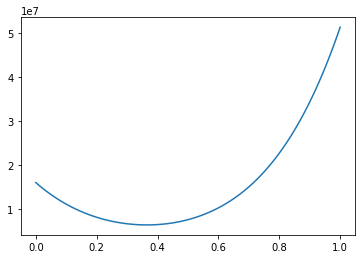

In [53]:
x0 = ntw.AoN(ntw.t_mat()) # AoN assignment only based on the free flow travel time
y0 = ntw.AoN(ntw.t_mat(x0))
Dalpha = 0.01
alpha_set = np.arange(0, 1+Dalpha, Dalpha)
plt.plot(alpha_set, [ntw.Z((1-alpha)*x0+alpha*y0) for alpha in alpha_set])

黄金分割法(golden section method)などによる一次元関数の最適化は `scipy.optimize.minimize_scalar` 関数によって実装されている．`lambda` を用いた無名関数(anonymous function)を用いれば，最適なαを求めるためのコードは以下のように記述できる．

In [54]:
from scipy import optimize
g = lambda alpha: ntw.Z((1-alpha)*x0+alpha*y0)
res = optimize.minimize_scalar(g, bounds=[0,1], method='golden')
alpha = res.x

同等の関数は `TNTP` にも実装されている:
- `FindAlpha(x,y)`: 暫定解`x`, 補助解`y` として最適なステップ・サイズを返す

$\mathbf{x}^{(n+1)} := \mathbf{x}^{(n)} + \alpha (\mathbf{y}^{(n)} - \mathbf{x}^{(n)})$ と暫定解を改訂しながら，正しく $g(\alpha)$を最小化させるステップ・サイズが求められていることを確認しよう．まず，下記のコマンドで初期解(自由走行時間のみをリンク費用と見なしてall-or-nothing配分したもの)を`x`に格納しておく．

In [55]:
x = ntw.AoN_init()  # give x0 as the first tentative solution

以下のセルを評価するたびに暫定解が改訂されていく．`Z=`の値が小さくなっていること，`alpha`が常に目的関数が最小となる点に一致するように求められることを確認しよう．

Z=4283234.86


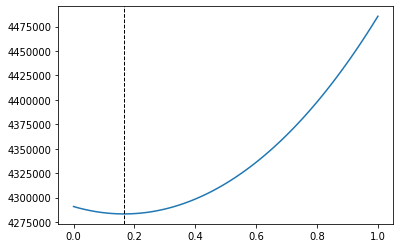

In [78]:
# evaluating this cell updates the tentative solution
y = ntw.AoN(ntw.t_mat(x))
alpha = ntw.FindAlpha(x,y)
alpha_set = np.arange(0, 1+Dalpha, Dalpha)
plt.plot(alpha_set, [ntw.Z((1-alpha)*x+alpha*y) for alpha in alpha_set])
plt.axvline(x = alpha, color='black', linestyle='dashed', linewidth=1)
x += alpha*(y-x)
print("Z=%8.2f"%ntw.Z(x))

## Convergence Test
上述の解の改訂を繰返すほど目的関数は徐々に小さくなっていく(i.e. リンク・フローが均衡解に漸近する)．一般的には，適当な条件を満足した時点で終了させる．ここでは，以下の3つの収束条件について，いずれかが満足された時点で終了することとしよう．
1. $n$回目繰返しにおける目的関数を$Z^{(n)}$とするとき，$\frac{Z^{(n-1)}-Z^{(n)}}{Z^{(n-1)}} \leq \epsilon_{Z}$
2. $n$回目繰返しにおけるリンク・フローを$x_{ij}^{(n)}$とするとき, $\frac{\sqrt{
\sum_{ij} \left( x_{ij}^{(n)} - x_{ij}^{(n-1)}\right)^{2}
}}{\sum_{ij} x_{ij}^{(n-1)}} \leq \epsilon_{x}$ 
3. $n$回目繰返しにおける，起点$r$からノード$i(\ne r)$への最小交通費用を$\pi_{i}^{r(n)}$ と記述する時,
  $
  \sum_{ri \in \mathcal{W}}
  \frac{\left|
  \pi_{i}^{r(n)} - \pi_{i}^{r(n-1)}
  \right|
  }
  {\pi_{i}^{r(n-1)}} \leq \epsilon_{\pi}$

In [86]:
# Parameters for convergence test
max_itr = 500 # the upper limit of iteration
TOL_Z_rate = 1e-6 # epsilon_Z
TOL_x_rate = 1e-5 # epsilon_x
TOL_pi_rate = 1e-5 # epsilon_pi

# Lists for log
Z = list() # objective function at each iteration
Z_rate = list() # change rate in the objective function
x_rate = list() # change rate in the link flow
pi_rate = list() # change rate in the shortest travel time

# initialize
t0 = ntw.t_mat()
x0 = ntw.AoN(t0)
pi0 = ntw.ShortestTravelTime(t0)
Z.append(ntw.Z(x0))

# main loop
for itr in range(max_itr):
    # Obtain the auxliary solution as the all-or-nothing assignment
    y = ntw.AoN(ntw.t_mat(x0))
    # Find the best step size
    alpha = ntw.FindAlpha(x0,y)
    # Update the tentative solution
    x = x0 + alpha*(y-x0)
    pi = ntw.ShortestTravelTime(ntw.t_mat(x))
    # Calculate change rates and update logs
    Z.append(ntw.Z(x))
    Z_rate.append((-Z[-1]+Z[-2])/Z[-2])
    pi_rate.append(sum(abs(pi[pi0>0]-pi0[pi0>0])/pi0[pi0>0]))
    x_rate.append(np.sqrt(np.sum((x0-x)**2))/(np.sum(x0)))
    # Convergence check
    if Z_rate[-1] < TOL_Z_rate or x_rate[-1] < TOL_x_rate or pi_rate[-1] < TOL_pi_rate:
        break
    # Memorize the current solution
    x0 = x.copy()
    pi0 = pi.copy()
    Z0 = Z

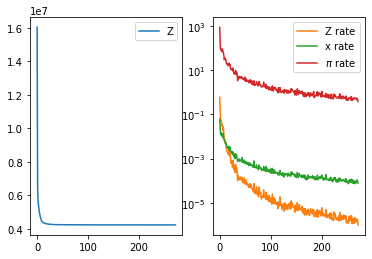

In [87]:
# Plot the convergence of Z, Z_rate, x_rate, pi_rate
plt.subplot(1,2,1)
plt.plot(Z,'C0', label="Z")
plt.legend()
plt.yscale('linear')
plt.subplot(1,2,2)
plt.plot(Z_rate, 'C1',label="Z rate")
plt.plot(x_rate, 'C2', label="x rate")
plt.plot(pi_rate, 'C3', label="$\pi$ rate")
plt.legend()
plt.yscale('log')

<BarContainer object of 76 artists>

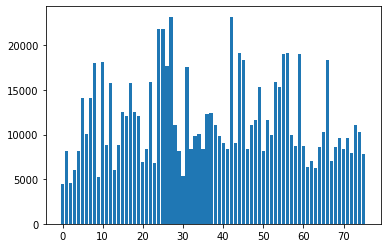

In [88]:
# show the link flow as bars
plt.bar(range(ntw.num_links), x)

`TNTP` モジュールには上述の手続きで均衡解を求めるための関数 `SolveUE` が用意されている．
`x = TNTP.SolveUE()` : 均衡フロー・パターンを求め `x` に代入する
`x, (Z, Z_rate, x_rate, pi_rate) = TNTP.SolveUE(return_log=True)` : 均衡フロー・パターンのみならず，目的関数`Z`, 目的関数の変化率`Z_rate`, リンク・フローの変化率`x_rate`, 最小所要時間の変化率`pi_rate` を返す
`x, (Z, Z_rate, x_rate, pi_rate) = ntw.SolveUE(TNTP.FW_Param(1000, 1e-7, 1e-6, 1e-6), return_log=True)`: `FW_Param`型でFrank-Wolfe法用のパラメータを与える．

Frank-Wolfe用のパラメータ・クラス`TNTP.FW_Param`は，以下の書式で初期化される:
```
TNTP.FW_Param(max_itr, TOL_Z_rate, TOL_x_rate, TOL_pi_rate)
```
ここで，
- `max_itr` : 繰返し回数の最大値
- `TOL_Z_rate` : 目的関数の変化率がこの値を下回れば収束と判定($\epsilon_Z$)
- `TOL_x_rate` : リンク・フローの変化率がこの値を下回れば収束と判定($\epsilon_x$)
- `TOL_pi_rate` : ノード間最小旅行時間の変化率がこの値を下回れば収束と判定($\epsilon_{\pi}$)